In [1]:
import cv2
import gc
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.engine import Layer
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD,RMSprop,adam
from keras.models import model_from_json
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, LeakyReLU, GlobalAveragePooling2D
from keras import regularizers
from keras.activations import relu, softmax, sigmoid, linear, elu
from sklearn.metrics import cohen_kappa_score
from keras.models import model_from_json

from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


In [3]:
img_rows = 528
img_cols = 528
channels = 3
batch = 4

In [4]:
import os
os.listdir('../input/')

['effnet',
 'aptos600all',
 'resultsb6-20',
 'aptos2019-blindness-detection',
 'resized-2015-2019-blindness-detection-images',
 'aptos600']

In [5]:
# # Read 2015 data
data15 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')
data15.rename(columns = {'image':'id_code', 'level':'diagnosis'}, inplace = True) 
data15['id_code'] = data15['id_code'] + ".jpg"
data15 = data15[['id_code','diagnosis']]
data15.head()

,id_code,diagnosis
0,10_left.jpg,0
1,10_right.jpg,0
2,13_left.jpg,0
3,13_right.jpg,0
4,15_left.jpg,1


In [6]:
# Read 2019 data
data19 = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
data19['id_code'] = data19['id_code'] + ".png"
data19 = data19[['id_code','diagnosis']] 
data19.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [7]:
data = pd.concat([data19, data15])
# data = data19
data.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [8]:
import gc

del data15
del data19
gc.collect()

26

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['id_code'].values, data['diagnosis'].values, test_size=0.2, random_state=24)

In [10]:
train = pd.DataFrame({'id_code':X_train,'diagnosis':y_train.astype('int')})
train.head(5)

,id_code,diagnosis
0,31428_right.jpg,0
1,5070_left.jpg,0
2,41579_right.jpg,0
3,10260_right.jpg,0
4,28091_right.jpg,0


In [11]:
val = pd.DataFrame({'id_code':X_val,'diagnosis':y_val.astype('int')})
val.head(5)

,id_code,diagnosis
0,11943_right.jpg,0
1,42857_right.jpg,0
2,263_right.jpg,0
3,3160_right.jpg,0
4,38570_right.jpg,0


In [12]:
datagen = ImageDataGenerator(preprocessing_function=None, rescale=1/255.)

train_generator = datagen.flow_from_dataframe(train, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = '../input/aptos600all/aptos600all/',
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch,
                                                    class_mode='raw', 
                                                    subset='training')

val_generator = datagen.flow_from_dataframe(val, 
                                                x_col='id_code', 
                                                y_col='diagnosis',
                                                directory = '../input/aptos600all/aptos600all/',
                                                target_size=(img_rows, img_cols),
                                                batch_size=batch,
                                                class_mode='raw', 
                                                subset='training')

Found 31030 validated image filenames.
Found 7758 validated image filenames.


In [13]:
sys.path.append(os.path.abspath('../input/effnet/efficientnet-master/'))
from efficientnet.keras import EfficientNetB6

In [14]:
input_tensor = Input(shape=(img_rows, img_cols, channels))
model = EfficientNetB6(include_top = False, weights = None, input_tensor=input_tensor)

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation=relu)(x)
x = Dropout(0.2)(x)
x = Dense(512, activation=relu)(x)
x = BatchNormalization()(x)
# outputs = Dense(5, activation='softmax')(x)
outputs = Dense(1, activation='linear') (x)

model = Model(inputs=model.input, outputs=outputs)
# model.summary()
# print(len(model.layers))
gc.collect()

In [15]:
# Uncomment if retraining
# Load json and create model
# json_file = open('../input/resultsb6-20/model_b6.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)

# Load weights into new model
# model.load_weights("../input/resultsb6-20/weights_kappa_b6.h5")
# print("Loaded model from disk")

Loaded model from disk


In [16]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / batch))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [17]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        
        :param epoch: The current epoch number
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save_weights("./weights_kappa_b6.h5")
        return
    
gc.collect()

8

In [18]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()

def schedule(epoch, lr):
    if epoch <= 3:
        lr = 5e-6
    else:
        lr = 1e-6
    return lr
LRS = LearningRateScheduler(schedule, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
filepath="./weights_best_val_b6.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.load_weights("../input/effnetb6-10/weights_kappa_b6.h5")
model.compile(loss='mse', optimizer = adam(lr=1e-6), metrics = ['acc'])

In [19]:
# Begin training
hist = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // batch,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // batch,
                    callbacks=[early_stop, kappa_metrics, checkpoint, LRS],
                    shuffle = True)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 5e-06.
2585/2585 [==============================] - 2580s 998ms/step - loss: 0.4252 - acc: 0.6795 - val_loss: 0.4582 - val_acc: 0.7297
val_kappa: 0.7479
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from inf to 0.45825, saving model to ./weights_best_val_b6.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 5e-06.
2585/2585 [==============================] - 2447s 947ms/step - loss: 0.4113 - acc: 0.6909 - val_loss: 0.1331 - val_acc: 0.7326
val_kappa: 0.7343

Epoch 00002: val_loss improved from 0.45825 to 0.13313, saving model to ./weights_best_val_b6.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 5e-06.
2585/2585 [==============================] - 2452s 948ms/step - loss: 0.4050 - acc: 0.6883 - val_loss: 0.3033 - val_acc: 0.7396
val_kappa: 0.7453

Epoch 00003: val_loss did not improve from 0.13313
Epoch 4/10

Epoch 00004: LearningRat

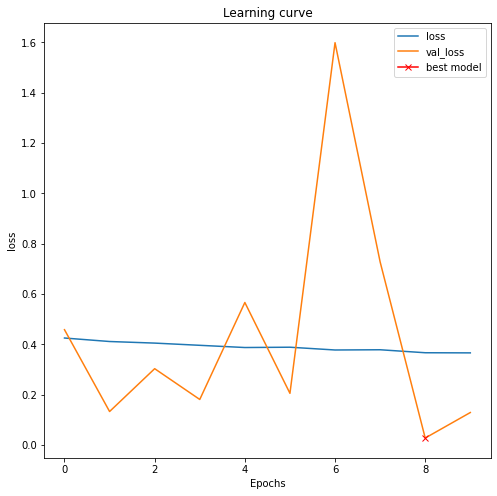

In [20]:
# visualizing losses and accuracy
train_loss = hist.history['loss']
val_loss = hist.history['val_loss'] 
train_acc = (hist.history['acc'])
val_acc = (hist.history['val_acc'])

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [25]:
# Save model and weights
model_json = model.to_json()
with open("./model_b6.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to H5
model.save_weights("./weights_b6.h5")
print("Saved model to disk")

Saved model to disk
